In [3]:
import pandas as pd
import numpy as np
import feather
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.preprocessing import RobustScaler
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
FILENAME = "final_data"
data = feather.read_dataframe(f"Datasets/{FILENAME}.feather")

### Train test split
Sample 100,000 instances to make testing faster.

In [21]:
temp = data.sample(100000, random_state=111).reset_index(drop=True)
X = temp.drop('Severity', axis=1)
y = temp['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=305)

# Testing Out Models

### Distribution of target variable (Zero-R classifier)

In [5]:
# Distribution of severity variable (as percentage)
temp["Severity"].value_counts()/len(temp)*100

0    74.747
1    25.253
Name: Severity, dtype: float64

### K-nearest neighbours

In [33]:
from sklearn.neighbors import KNeighborsClassifier

ks = range(6,100,4)
train_accs = []
test_accs = []

for k in ks:
    nn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_accs.append(accuracy_score(y_train, nn.predict(X_train)))
    test_accs.append(accuracy_score(y_test, nn.predict(X_test)))

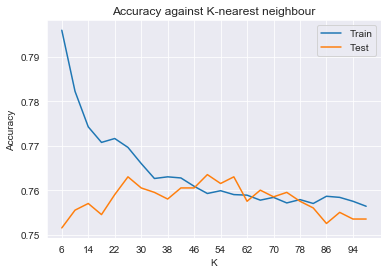

Maximum test accuracy (0.7635) occurs when K = 50


In [37]:
sns.set_style("darkgrid")

plt.plot(ks, train_accs, label='Train')
plt.plot(ks, test_accs, label='Test')
plt.ylabel('Accuracy')
plt.xlabel("K")
plt.xticks(range(6,100,8))
plt.title("Accuracy against K-nearest neighbour")

plt.legend()
plt.show()

max_acc = max(test_accs)
print(f"Maximum test accuracy ({max_acc}) occurs when K = {ks[test_accs.index(max_acc)]}")

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

# lgr = LogisticRegression(solver='liblinear')
# lgr.fit(X_train,y_train)
# print("Basic logistic Regression Accuracy:", lgr.score(X_test,y_test))

In [40]:
clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2'],
        'class_weight': ['balanced']}
clf_lr = GridSearchCV(clf_base, grid, cv=5, n_jobs=8, scoring='f1_macro')

clf_lr.fit(X_train, y_train)

coef = clf_lr.best_estimator_.coef_
intercept = clf_lr.best_estimator_.intercept_
print (classification_report(y_test, clf_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.70      0.78     14891
           1       0.44      0.68      0.53      5109

   micro avg       0.70      0.70      0.70     20000
   macro avg       0.65      0.69      0.65     20000
weighted avg       0.76      0.70      0.71     20000



In [41]:
accuracy_score(y_test, clf_lr.predict(X_test))

0.6969

### SVM

In [6]:
svc = svm.SVC(kernel="linear", C=0.01, probability=True)
svc.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
accuracy_score(y_test, svc.predict(X_test))

0.75005

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), svm.SVC(kernel="linear", C=0.01, probability=True))

In [11]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [12]:
accuracy_score(y_test, clf.predict(X_test))

0.74555

### Neural Network

In [6]:
def my_nn(X_train,y_train,X_test,y_test,neuron_size,epoch_size, extra_info=0):
    # constructing the neural network. Returns the test accuracy
    BATCH_SIZE = 128
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neuron_size,input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(int(2/3*neuron_size), activation=tf.nn.leaky_relu))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epoch_size, batch_size=BATCH_SIZE, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = [0 if i[0]<0.5 else 1 for i in y_pred] #Convert to 0 and 1
    test_acc = accuracy_score(y_test, y_pred)
    if extra_info:
        # if want to display extra metrics and a confusion matrix
        print("Precision: ", precision_score(y_test,y_pred))
        print("Recall:    ", recall_score(y_test,y_pred))
        print("F1 score:  ", f1_score(y_test,y_pred))
        
        cm=confusion_matrix(y_test,y_pred)
        cm = pd.DataFrame(cm, index = [i for i in "01"],
                          columns = [i for i in "01"])
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        sns.heatmap(cm, annot=True, 
                    cmap='Blues', cbar=False)
        plt.title("Confusion matrix")
        plt.show()
        
    return test_acc

In [99]:
skf = StratifiedKFold(n_splits=5, random_state=30034, shuffle=True)
fold_no = 1
accs = []  # store each accuracy
X = RobustScaler(quantile_range=(25, 75)).fit_transform(X)

for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    acc = my_nn(X_train,y_train,X_test,y_test,30,10)
    accs.append(acc)
    print(f"Fold {str(fold_no)} test accuracy = {acc}")
    fold_no+=1
    
print("Average Accuracy: ",np.mean(accuracies))

Fold 1 test accuracy = 0.7737113144342783
Fold 2 test accuracy = 0.775411229438528
Fold 3 test accuracy = 0.7743
Fold 4 test accuracy = 0.7752887644382219
Fold 5 test accuracy = 0.7713885694284714
Average Accuracy:  0.7738999999999999


| Model | Best test accuracy |
| --- | --- |
| Zero-R (Baseline) | 74.75 |
| Logistic Regression | 69.69 |
| SVM | 75.01 |
| 50-nearest neighbours | 76.35 |
| Neural network | 77.39 |

Since the neural network seems to be performing the best, I will choose to explore this model further and tune the hyperparameters.

# Improving the neural network model

In [4]:
temp = data.sample(500000, random_state=111).reset_index(drop=True)
X = temp.drop('Severity', axis=1)
y = temp['Severity']

X = RobustScaler(quantile_range=(25, 75)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=305)

### Number of neurons

In [19]:
X.shape

(500000, 81)

In [8]:
accs = []
neuron_size = range(10, X.shape[1], 5) # the number of neurons need to be between 0 and number of features

for i in neuron_size:
    acc = my_nn(X_train,y_train,X_test,y_test,i,10)
    accs.append(acc)

Max accuracy (0.77856) when neuron size = 60


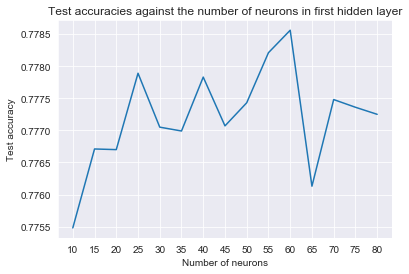

In [9]:
#plotting line graph of accuracy vs neuron_size
sns.set_style("darkgrid")
plt.plot(neuron_size, accs)
plt.xlabel("Number of neurons")
plt.xticks(neuron_size)
plt.ylabel("Test accuracy")
plt.title("Test accuracies against the number of neurons in first hidden layer")
best_neuron_size = neuron_size[np.argmax(accs)]
print(f"Max accuracy ({max(accs)}) when neuron size = {best_neuron_size}")

### Early stopping

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100,input_dim=X_train.shape[1], activation='relu'))
model.add(tf.keras.layers.Dense(int(2/3*100), activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,y_train,validation_split=0.2, verbose=0,epochs=40)

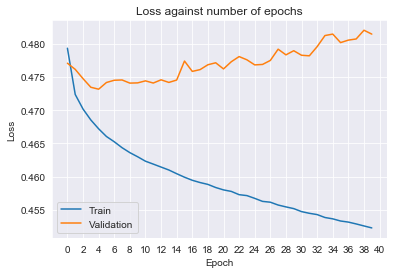

In [12]:
sns.set_style("darkgrid")

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.xticks(range(0,41,2))
plt.title("Loss against number of epochs")

plt.legend()
plt.show()

Since the validation lost seems to increase around 5 epochs onwards, there is no point using a greater number of epochs since it will cause overfitting. 

# Final evaluation

In [13]:
X = data.drop('Severity', axis=1)
X = RobustScaler(quantile_range=(25, 75)).fit_transform(X)
y = data['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=305)

EPOCHS = 5
NEURON_SIZE = 60

### Train test split

Precision:  0.6230555734847996
Recall:     0.31994652642743504
F1 score:   0.42278689840938455


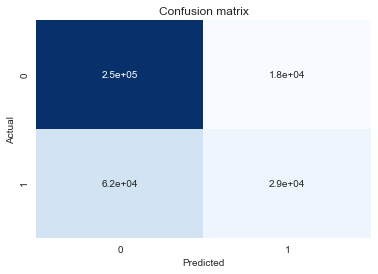

Test accuracy for simple train test split = 0.7782566875212075


In [14]:
acc = my_nn(X_train, y_train,X_test,y_test, NEURON_SIZE, EPOCHS, extra_info=1)
print(f"Test accuracy for simple train test split = {acc}")

### Stratified k fold

In [15]:
X = data.drop('Severity', axis=1)
X = RobustScaler(quantile_range=(25, 75)).fit_transform(X)
y = data['Severity']

EPOCHS = 5
NEURON_SIZE = 40

skf = StratifiedKFold(n_splits=5, random_state=30034, shuffle=True)
fold_no = 1
accs = []  # store each accuracy

for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    acc = my_nn(X_train,y_train,X_test,y_test,NEURON_SIZE,EPOCHS)
    accs.append(acc)
    print(f"Fold {str(fold_no)} test accuracy = {acc}")
    fold_no+=1

Fold 1 test accuracy = 0.7781389075062325
Fold 2 test accuracy = 0.7765320515876466
Fold 3 test accuracy = 0.7781893846555075
Fold 4 test accuracy = 0.7791764933524399
Fold 5 test accuracy = 0.7785000392601151


In [16]:
print("Average Accuracy: ",np.mean(accs))

Average Accuracy:  0.7781073752723883


Given that around 74.75% of the data are distributed towards low severity accidents, the model is
considered under performing. The accuracy of the final model is only 3% higher than a 0-R
baseline model.